# Building an Uncertainty-Aware MNIST Digit Classifier using Cirkit


## Goals

By the end of this tutorial you will:

* Know how to build a multi-class classifier using cirkit
* Understand how to train the model generatively and discriminatively
* Understand how to easily produce variants of your classifier


In this notebook we will loosely follow the [RAT SPN paper]().
For the paper, the authors had to implement all the circuit operations from scratch in tensorflow, because Cirkit did not exist!

### Enter Cirkit &#x1F50C; &#x26A1;	
Cirkit's modularity makes building circuits like those used in the RAT SPN paper extremely easy.
We will show this by:

1. Reimplementing the MNIST experiments of the RAT SPN paper with just a few lines of code
2. Illustrating how to easily adapt/improve models with plug & play modules

# Load Image Data  &#x1F5BC;	&#x1F5B4;

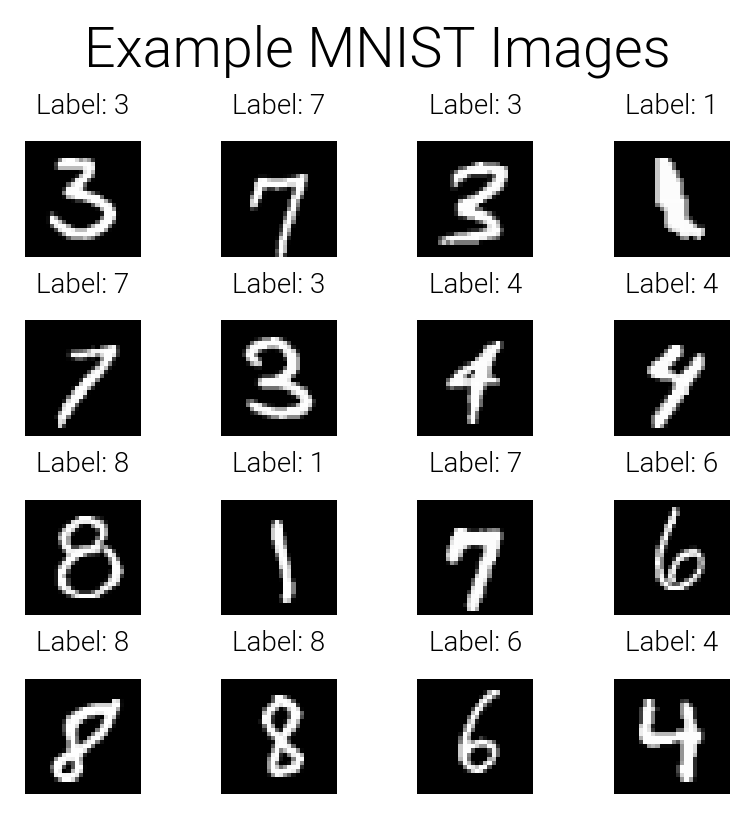

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms, datasets


PIXEL_RANGE= 255
IMAGE_SIZE = [28, 28]


NUM_CLASSES = 10 # Number of digits in MNIST
LOG_NUM_CLASSES = np.log(NUM_CLASSES)
LOG_NUM_DISTINCT_IMAGES = np.log(PIXEL_RANGE+1) * np.prod([IMAGE_SIZE]) # Log Number of distinct possible images

# Store an example image
example_image = None

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (PIXEL_RANGE * x).long())
])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    images, labels = next(iter(dataloader))
    
    example_image = images[0]
    images = images[:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images')
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Call the function to plot images
plot_sample_images(train_dataloader, gridsize=4)

# Building a Digit Classifier using Cirkit &#x1F50C;

In this section, we show how to train our circuit such that it can classify MNIST digits.
We will show 3 ways of training:

1. Generative Training
2. Discriminative Training
3. Combination of Both (i.e. using a multi-task objective)

### Notation

* $\mathbf{x}$ are the pixels of an image
* $y$ is the MNIST digit class, i.e. $y \in \{0,\ldots,9\}$
* $N$ is the number of training examples

## 1. Generative Training Objective

### Modelling $P(x)$ directly
We have [already seen](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb) how we can fit a circuit to estimate the likelihood of our images, i.e. $P(x)$. Recall that when we were modelling $P(\mathbf{x})$ directly, our circuit had a single log-probability output, which we interpreted as $\log P(\mathbf{x})$.
**But what if we want to also model the class of each image?**

### Modelling $P(x)$ by also including the digit class, i.e. $P(x \mid y)$.

In order to include the class image in our mode, we can fit $P(\mathbf{x} \mid y)$ for $y \in \{ 0 \ldots 9 \}$.
We can then obtain $P(x)$ by marginalising out $y$:

$$
P(x) = \sum_{y} P(x \mid y) P(y)
$$

### Fitting $P(x \mid y)$ for $y \in \{ 0\ldots 9 \}$
But how do we construct a circuit to give us these conditional distributions?
One choice is to fit $10$ separate circuits, one per image class. However, this is wasteful.
Images have characteristics that all these models would have to re-learn from scratch, separately.
Can we do better?


### Parameter Sharing
Yes! We can use **parameter sharing**. I.e., we share the early layers of our circuit and only adapt the output layer of our circuit.
We change the last layer of our circuit to output $10$ log-probabilities: the probability mass over images for each class.
We show how to implement this below.

In [10]:
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree, RegionGraph
from cirkit.symbolic.layers import CategoricalLayer
from cirkit.templates.circuit_templates.utils import Parameterization, parameterization_to_factory
from cirkit.templates.region_graph import QuadGraph


NUM_INPUT_UNITS = 64
NUM_SUM_UNITS = 64


def build_class_conditional_classifier(num_classes: int,
                                       rg: RegionGraph,
                                       sum_prod_layer: str = 'cp') -> Circuit:
    input_factory = lambda scope, y, z: CategoricalLayer(
        scope=scope,
        num_categories=PIXEL_RANGE+1,
        num_channels=1, # These are grayscale images
        num_output_units=NUM_INPUT_UNITS # Overparameterization
    )

    # Note that below intialisation is needed
    sum_weight_param = Parameterization(activation='softmax', initialization='normal')
    sum_weight_factory = parameterization_to_factory(sum_weight_param)
    
    circuit = Circuit.from_region_graph(
        rg,
        input_factory=input_factory,
        sum_weight_factory= sum_weight_factory,
        num_sum_units=NUM_SUM_UNITS,
        sum_product=sum_prod_layer,
        num_classes=num_classes,
    )
    return circuit


qt = QuadGraph(IMAGE_SIZE)
circuit = build_class_conditional_classifier(NUM_CLASSES, qt, 'cp')

<div style="max-width:30%; margin: auto;">
    
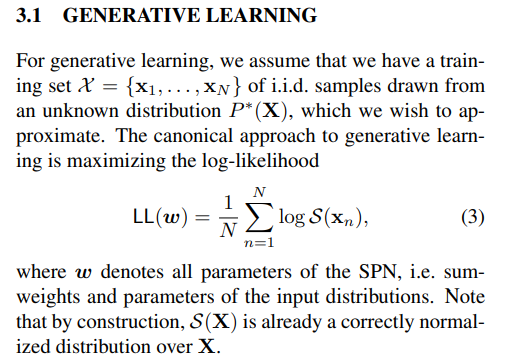

</div>

### Generative Loss in Code
```python
def generative_loss(log_probs, labels, marginalize=False, prior=None):
    batch_size, num_classes = log_probs.shape

    if marginalize:
        # Set prior to uniform if not set
        prior = prior or torch.ones(num_classes, device=log_probs.device) / num_classes
        d_log_probs = torch.logsumexp(log_probs + torch.log(prior), dim=1)
    else:
        # Choose the logprob given by y - i.e. the true label
        d_log_probs = log_probs[torch.arange(batch_size), labels]
    return -torch.mean(d_log_probs)
```



## 2. Discriminative Training Objective

> What about modelling $P(y \mid x)$?

<div style="max-width:30%; margin: auto;">
    
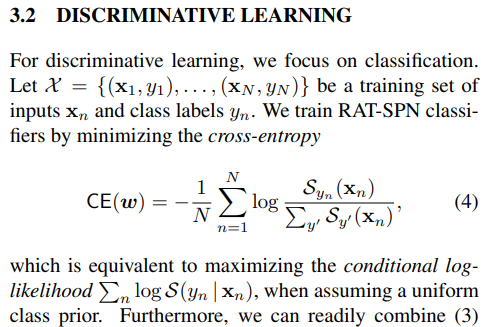

</div>

### Using Bayes' rule to make our Generator a Classifier


$$P(y \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y)P(y)}{\sum_y P(\mathbf{x} \mid y)P(y)}$$

### Uniform Prior
While we could estimate $P(y)$ empirically, here we assume a uniform prior, for simplicity. Doing so allows us to simplify the above expression to:

$$P(y \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y)}{\sum_y P(\mathbf{x} \mid y)}$$

### Log form

We use log probabilities for numerical reasons, so the above would be:

$$\log P(y \mid \mathbf{x}) = \log P(\mathbf{x} \mid y) - \log \sum_y P(\mathbf{x} \mid y)$$

### Discriminative Loss in Code
```python
def discriminative_loss(log_probs, labels):
    batch_size, num_classes = log_probs.shape
    # Choose the logprob given by y - i.e. the true label
    d_log_probs = log_probs[torch.arange(batch_size), labels] - torch.logsumexp(log_probs, dim=1)
    return -torch.mean(d_log_probs)
```

## 3. Combining Both Objectives


The RAT SPN papepr also considers training using a trade-off between the two objectives.
To do so, it introduces a parameter $\lambda \in [0, 1]$ and computes a combined loss as:

<div style="max-width:30%; margin: auto;">
    
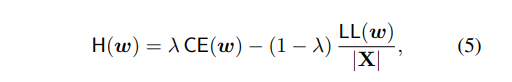

</div>

In [18]:
from collections import defaultdict
from cirkit.pipeline import compile


class ClassConditionalClassifier(object):

    """Docstring for ClassConditionalClassifier. """

    def __init__(self, model, interpolation=.5, scale_gen=1., scale_dis=1.):
        self.model = model
        assert 0 <= interpolation <= 1
        self.interpolation = interpolation
        self.scale_gen = scale_gen
        self.scale_dis = scale_dis

    def __call__(self, xx, yy):

        log_probs = self.model(xx)

        batch_size, num_channels, num_classes = log_probs.shape
        assert num_channels == 1
        assert num_classes > 1

        # Remove channel dim (which is one)
        log_probs = log_probs.squeeze(dim=1)

        gen_loss = self.generative_loss(log_probs, yy)
        dis_loss = self.discriminative_loss(log_probs, yy)

        loss = self.interpolation * gen_loss * self.scale_gen + (1 - self.interpolation) * dis_loss * self.scale_dis

        probs = torch.exp(log_probs - torch.logsumexp(log_probs, dim=1, keepdims=True))

        return dict(loss=loss, probs=probs)

    @staticmethod
    def generative_loss(log_probs, labels, marginalize=False, prior=None):
        batch_size, num_classes = log_probs.shape

        if marginalize:
            # Set prior to uniform if not set
            prior = prior or torch.ones(num_classes, device=log_probs.device) / num_classes
            d_log_probs = torch.logsumexp(log_probs + torch.log(prior), dim=1)
        else:
            # Choose the logprob given by y - i.e. the true label
            d_log_probs = log_probs[torch.arange(batch_size), labels]
        return -torch.mean(d_log_probs)

    @staticmethod
    def discriminative_loss(log_probs, labels):
        batch_size, num_classes = log_probs.shape
        # Choose the logprob given by y - i.e. the true label
        d_log_probs = log_probs[torch.arange(batch_size), labels] - torch.logsumexp(log_probs, dim=1)
        return -torch.mean(d_log_probs)


# Set the torch device to use
device = torch.device('cuda')

model = compile(circuit)
# Move the circuit to chosen device
model = model.to(device)
model.train()


cc = ClassConditionalClassifier(model,
                                interpolation=1.,
                                scale_gen=1./LOG_NUM_DISTINCT_IMAGES,
                                scale_dis=1./LOG_NUM_CLASSES)


# Set some seeds
np.random.seed(42)
torch.manual_seed(42)

print_every = 200
num_epochs = 10
step_idx = 0
stats = defaultdict(float)

# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


for epoch_idx in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        BS = images.shape[0]
        
        images = images.view(BS, 1, -1).to(device)
        labels = labels.view(BS).to(device)
        

        result = cc(images, labels)
        
        loss = result['loss']
        loss.backward()

        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()

        # Get digit probabilities
        probs = result['probs']
        # Predict the digit with the largest probability
        preds = torch.argmax(probs, dim=1)
        acc = torch.mean((preds == labels).float())
        
        stats['loss'] += loss.detach() * BS
        stats['accuracy'] += acc.detach() * BS
        step_idx += 1
        if step_idx % print_every == 0:
            average_loss = stats['loss'] / (print_every * BS)
            average_acc = stats['accuracy'] / (print_every * BS)
            print(f"Step {step_idx}: Average Loss: {average_loss:.3f}: Average Accuracy: {average_acc * 100:.2f}%")
            stats = defaultdict(float)

Step 200: Average Loss: 0.140: Average Accuracy: 94.08%
Step 400: Average Loss: 0.140: Average Accuracy: 93.87%
Step 600: Average Loss: 0.140: Average Accuracy: 93.69%
Step 800: Average Loss: 0.140: Average Accuracy: 93.78%
Step 1000: Average Loss: 0.139: Average Accuracy: 93.95%
Step 1200: Average Loss: 0.140: Average Accuracy: 93.78%
Step 1400: Average Loss: 0.140: Average Accuracy: 94.15%
Step 1600: Average Loss: 0.140: Average Accuracy: 93.76%
Step 1800: Average Loss: 0.140: Average Accuracy: 93.94%
Step 2000: Average Loss: 0.140: Average Accuracy: 93.77%
Step 2200: Average Loss: 0.140: Average Accuracy: 93.93%


In [34]:
with torch.no_grad():
    test_lls = 0.0
    model.eval()

    for images, labels in test_dataloader:
        BS = images.shape[0]
        
        images = images.view(BS, 1, -1).to(device)
        labels = labels.view(BS).to(device)

        # Compute the log-likelihoods of the batch, by evaluating the circuit
        cond_log_likelihoods = model(images).view(BS, -1)

        
        # At this point, we can either marginalise and ignore the y info
        # or we can maximise the likelihood of the image under the label
        cond_lls = cond_log_likelihoods[np.arange(BS), labels]

        # Accumulate the log-likelihoods
        test_lls += cond_lls.sum().item()

    # Compute average test log-likelihood and bits per dimension
    average_nll = - test_lls / len(data_test)
    bpd = average_nll / (28 * 28 * np.log(2.0))
    print(f"Average test LL: {average_nll:.3f}")
    print(f"Bits per dimension: {bpd:.3f}")

    stats['test loss'] = average_nll
    stats['test bits per dimension'] = bpd

Average test LL: 655.431
Bits per dimension: 1.206


# Taking it a step further

In [129]:
# quad-graph
# (mu)SOCS and PICS